# MRI Coding Challenge

## Questions

In [1]:
# How much variance is there between the two sessions this subject underwent? Is there any way to make 
# the random forest do anything but angrily say "no"?

## TODOS

In [2]:
# TODO: write a loop that outputs, at slice 15, intensity values above threshold for each session.
# TODO: Figure out how to determine what threshold to use.
# TODO: figure out what 'first-order analysis' means.
# TODO: figure out how random forest classifiers work.
# TODO: learn what out-of-bag error means.
# TODO: learn what a class conditional posterior estimated random forest is.
# TODO: Slider widget that moves through time (for fun if I have time)
# TODO: Slider widget that moves through z-axis (for fun if I have time)

## Get the data

**Goals:**

- Load up both datasets from nifti files
- Load up all necessary libraries.

In [224]:
import pandas as pd  # in case I need it
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, suppress=True)  # For clarity
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # For clarity

In [4]:
mri1 = nib.load('sub-0025865_ses-1_dwi_aligned.nii')
mri2 = nib.load('sub-0025865_ses-2_dwi_aligned.nii')

In [5]:
mri1_data = mri1.get_data()  # Turn into numpy data. This appears to be only an axial section.
mri2_data = mri2.get_data()

## First impressions of the data

**Goals:**

- Get a sense for what this data looks like.

In [7]:
mri1_data.shape

(182, 218, 182, 31)

In [9]:
mri1.shape == mri2.shape

True

In [10]:
hdr = mri1.header  # metadata about the image

In [12]:
hdr.get_xyzt_units()
# Time is in seconds, size units are in millimeters.
# So I think this means each of the 30 time images comprise a second, and each scan contains 30 seconds of data,
# and each slice is one more millimeter vertically. This shall be the working hypothesis given no new information.

('mm', 'sec')

In [131]:
mri1.affine  # This relates voxel coordinates to real-world coordinates with a linear transformation.

array([[ -1.,   0.,   0.,  90.],
       [  0.,  -1.,   0.,  91.],
       [  0.,   0.,   1., -72.],
       [  0.,   0.,   0.,   1.]])

In [14]:
mri1_data.dtype

dtype('<i2')

## Scale the Data

**Task:**
- Figure out what the distribution of array values looks like.

In [139]:
pd.Series(mri1_data[:, :, :, 0].ravel()).describe()

count   7221032.00
mean        137.47
std         214.25
min        -138.00
25%           8.00
50%          21.00
75%         248.00
max        4369.00
dtype: float64

**Results:**

- Mean of 137 across the whole dataset.
- Min of -138.
- Max at 4369, but with a 75% of 248

**Next Step:**

- Get some histograms to look at what this looks like across z- slices.
- Probably going to want to scale somewhere around vmin=0, vmax=200-500.

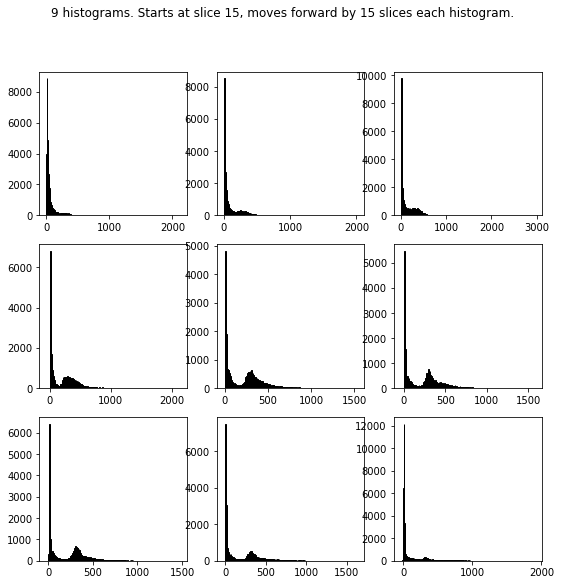

In [118]:
# TODO: scale data
# REMEMBER: first time-point (of the 31 time points) is a high-contrast point prior to testing

fig, ax = plt.subplots(3, 3, figsize=(9,9))

for i, axi in enumerate(ax.flat):
    axi.hist(mri1_data[:, :, (15*i + 15), 0].ravel(), bins=256,
             fc='k', ec='k');  # Use first time-point. Most of the interesting stuff is at the peak, which is near 70

plt.suptitle('9 histograms. Starts at slice 15, moves forward by 15 slices each histogram.');

**Results:**


- Most spikes are in the range of [0, 500]
- Any outliers are going to skew the contrast, because the value determining a white pixel is based on the maximum value in a numpy array.
- First slices have values closer to 0 on average, likely because less of the brain is showing and there's more black space.
- This means that setting vmax to 248 (the 75th percentile) might be bad for later slices

***

**Scaling:**
- Set vmin=0, vmax=500 (based on the histograms) for overall data.
- Set vmin=0, vmax=200 (based on the first histogram) for slice 15 specifically.

## Plot the Data

- Now that scaling is determined, plot time=5 and z slice=15.

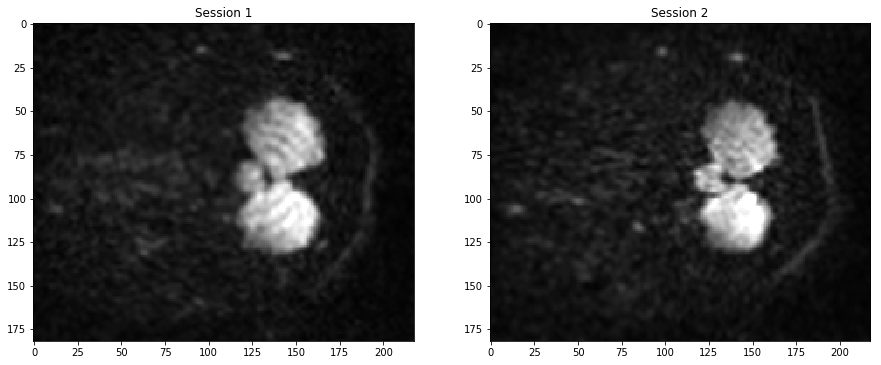

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 20))
z, t = 15, 5  # time begins with the high-contrast image, so I don't have to worry about 0-indexing.

ax1.imshow(mri1_data[:, :, 15, 20], cmap='gray', vmin=0, vmax=200)  # z=15 is where full image begins, z=150 is where full image ends
ax2.imshow(mri2_data[:, :, 15, 5], cmap='gray', vmin=0, vmax=200)

ax1.set_title('Session 1');
ax2.set_title('Session 2');

## Crop out a brain area, plot that region for each session

In [168]:
# Cerebellum is fun, and easy to see
cerebellum1 = mri1_data[35:145, 100:180, 15:60, :]  # All time slices for specifically the cerebellum.
cerebellum2 = mri2_data[35:145, 100:180, 15:60, :]  # Slices determined by experimentation.

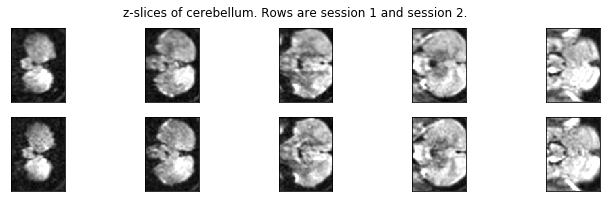

In [256]:
# TODO: figure out how to label the rows

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(12, 3))

t, z, n = 5, 0, 0  # z-slice, time, and axis we're currently on
for i in range(5):
    ax1[n].imshow(cerebellum1[:, :, z, t], cmap='gray', vmin=0, vmax=200)
    ax2[n].imshow(cerebellum2[:, :, z, t], cmap='gray', vmin=0, vmax=200)
    
    ax1[n].set_xticks([])
    ax2[n].set_xticks([])
    ax1[n].set_yticks([])
    ax2[n].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('Session 1', color='r', fontsize=5)
        ax[1][i].set_ylabel('Session 2', color='r', fontsize=5)
    
    n += 1
    z += 9  # Because there are 5 plots for each session, and 45 z-slices that comprise the cerebellum.

fig.subplots_adjust(wspace=0)
plt.suptitle('z-slices of cerebellum. Rows are session 1 and session 2.');

## Choose an intensity value at slice 15, return number of pixels above that threshold for each session

**Choosing threshold value: **

In [229]:
pd.Series(mri1_data[:, :, 15, :].ravel()).describe()

count   1229956.00
mean         28.06
std          41.76
min          -3.00
25%          11.00
50%          16.00
75%          24.00
max        2126.00
dtype: float64

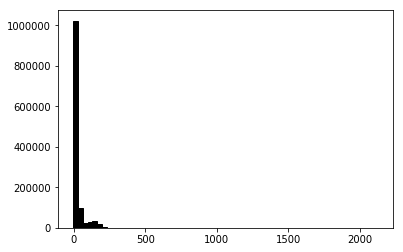

In [232]:
plt.hist(mri1_data[:, :, 15, :].ravel(), bins=64, fc='k', ec='k');

- 75th percentile is at 24. Let's see how many outliers there are for each session.
- I will define an outlier as being any value above 24 in the flattened numpy array corresponding to image data at slice 15.

### Return number of pixels above 24 at slice 15 for each session

In [234]:
mri1_ravel = mri1_data[:, :, 15, :].ravel()
mri2_ravel = mri2_data[:, :, 15, :].ravel()

In [248]:
len(mri1_ravel[mri1_ravel > 24])

303507

In [247]:
len(mri2_ravel[mri2_ravel > 24])

285490

- At slice 15 on the z-axis, the first session has 303507 pixels with value higher than 24.
- At slice 15 on the z-axis, the second session has 285490 pixels with value higher than 24.

## Using threshold, perform first-order analysis

In [29]:
# TODO: figure out what 'first-order analysis' means.

## Train a random forest classifier to differentiate between sessions.

### Need out-of-bag error and distribution of cllass conditional posteriors

In [30]:
# TODO: figure out how random forest classifiers work.
# TODO: learn what out-of-bag error means.
# TODO: learn what a class conditional posterior estimated random forest is.

In [31]:
from sklearn.ensemble import RandomForestClassifier  # This should be the one
# Read through source code here
# invidual trees available in estimators_
# export_graphvis: for visualizing trees

??RandomForestClassifier

Init signature: RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
Source:        
class RandomForestClassifier(ForestClassifier):
    """A random forest classifier.

    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and use averaging to
    improve the predictive accuracy and control over-fitting.
    The sub-sample size is always the same as the original
    input sample size but the samples are drawn with replacement if
    `bootstrap=True` (default).

    Read more in the :ref:`User Guide <forest>`.

    Parameters
    ----------
    n_estimators : integer, optional (default=10)
        The number of trees in t